In [2]:
import numpy as np
import seaborn as sb
import pandas
import sys
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
import torch
import time
import pickle
%matplotlib notebook

In [4]:
# load cifar and lfw datasets from disk
with open('../data/faces_python.pkl', 'rb') as fo:
    lfwdata=pickle.load(fo)
    
with open('../data/nonfaces_python.pkl', 'rb') as fo:
    cifardata=pickle.load(fo)

# train-test split
train_test_split = 0.2

# prepare faces
tmp1 = np.round(lfwdata.shape[0]*train_test_split).astype(int)
train_ct1 = np.ones(tmp1) 
test_ct1 = np.ones((lfwdata.shape[0]-tmp1,1))
train_ci1 = lfwdata[:tmp1,:] 
test_ci1 = lfwdata[tmp1:,:]

# prepare non-faces
# note that CIFAR has a lot more images, so here we 
# restrict also this dataset to the same number of images
# as the face dataset!
tmp2 = np.round(lfwdata.shape[0]*train_test_split).astype(int)
train_ct2 = np.zeros(tmp2) 
test_ct2 = np.zeros((lfwdata.shape[0]-tmp2,1))
train_ci2 = cifardata[:tmp2,:] 
test_ci2 = cifardata[tmp2:lfwdata.shape[0],:]

# now concatenate arrays
train_ct12 = np.concatenate((train_ct1,train_ct2),axis=0)
train_ci12 = np.concatenate((train_ci1,train_ci2),axis=0)

test_ct12 = np.concatenate((test_ct1,test_ct2),axis=0)
test_ci12 = np.concatenate((test_ci1,test_ci2),axis=0)


torch.Size([5294, 1024]) torch.Size([5294])


C:\Users\cwall\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([5294])) that is different to the input size (torch.Size([5294, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


<IPython.core.display.Javascript object>


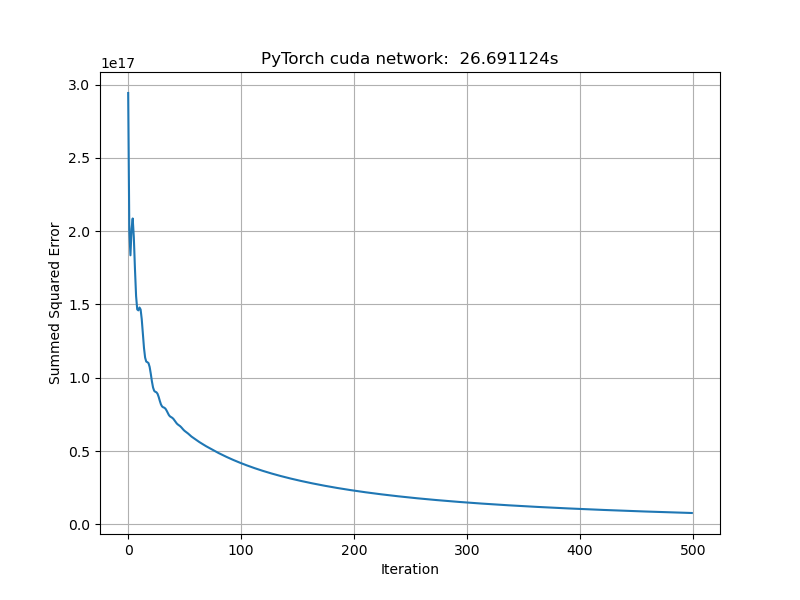

In [3]:
doGPU=True
if (doGPU):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    

x =  torch.from_numpy(train_ci12).float().to(device)
y =  torch.from_numpy(train_ct12).float().to(device)

print(x.shape,y.shape)

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1024, 10000, 1

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, D_out),
        ).to(device)

def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        size = m.weight.size() # returns a tuple
        fan_out = size[0] # number of rows
        fan_in = size[1] # number of columns
        m.weight.data = torch.randn(fan_out, fan_in, device=device)

model.apply(weights_init)

loss_fn = torch.nn.MSELoss(reduction='sum')

max_iterations = 500
l2_errors = np.zeros(max_iterations)

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algorithms. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start=time.time()


for it in range(max_iterations):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    l2_errors[it]=loss.item()

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the Tensors it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its parameters
    optimizer.step()
    
total_time = time.time()-start
fig,ax = plt.subplots(figsize=(8,6))
plt.plot(l2_errors)
plt.xlabel('Iteration')
plt.ylabel('Summed Squared Error')
plt.title('PyTorch {0:} network: {1: 0.6f}s'.format(device,total_time))
plt.grid()

In [4]:
np.mean(lfwdata[0])

0.5246333103553922